In [2]:
import pygame
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from wfc import rules_from_image
from wfc.helpers import show_tiles
from wfc.game import SchrodingerSpriteGen

In [4]:
sprite_size = 16
tiles, hashes, rules = rules_from_image("wfc_tiles/source.png", sprite_size)

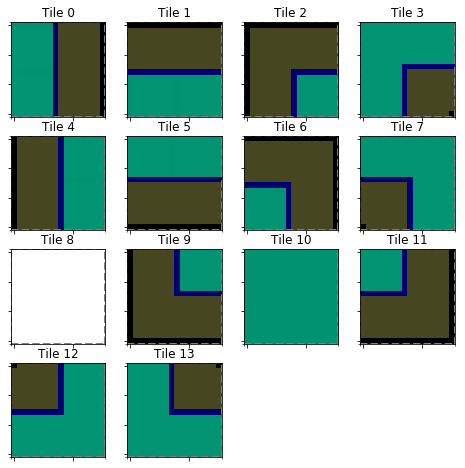

In [5]:
show_tiles(hashes, tiles)

In [6]:
size = 40
field = [[random.randint(0,len(hashes)-1) for x in range(size)] for y in range(size)]

In [7]:
SchrodingerSprite = SchrodingerSpriteGen(tiles, hashes, "wfc_tiles/error.png")

In [ ]:
pygame.init()

screen = pygame.display.set_mode([size*sprite_size, size*sprite_size])
pygame.display.set_caption("WFC Test")
 
all_sprites_list = pygame.sprite.Group()
my_sprites_list = []

fld = field.copy()
for i in range(size):
    for j in range(size):
        spr = SchrodingerSprite(i*sprite_size,j*sprite_size,set([fld[j][i]]))
        #spr = SchrodingerSprite(i*sprite_size,j*sprite_size,set(range(len(sprites_rot))))
        all_sprites_list.add(spr)
        my_sprites_list.append(spr)

def regenerate_init():
    for x in range(size): 
        for y in range(size):
            my_sprites_list[x+y*size].setCode(set(range(len(hashes))))
        screen.fill(WHITE)
        all_sprites_list.draw(screen)
        pygame.display.flip()

def apply_rules(Cc, Cx, d, debug=False):
    if debug:
        for c in Cc:
            print("Possible candidates for " + str(c) + " are:", np.where(rotRules(c//len(sprites))[c%len(sprites),d].flatten())[0].tolist() )
    tcs = [set(np.where(rotRules(c//len(sprites))[c%len(sprites),d].flatten())[0].tolist()) for c in Cc]
    if len(tcs)>0:
        tc = set.union(*tcs)
    else:
        if debug:
            print("CONFLICT")
        tc = set(range(len(sprites_rot)))
    if debug:
        print("Resulting candidates", tc)
        print("Intersect with", Cx)
    return set.intersection(Cx,tc)

def collapse(x, y, debug=False):
    if debug:
        print("Called collapse with args",x,y)
    C = my_sprites_list[x+y*size]
    propagation = []
    
    Ct = my_sprites_list[((x-1)%size+y*size)%len(my_sprites_list)]
    if debug:
        print("Top before collapse", Ct.codes)
    Ctc = applyRules(C.codes, Ct.codes, 0, debug)
    if debug:
        print("Final top states", Ctc)
    if Ct.codes != Ctc:
        propagation.append(((x-1)%size,y))
    Ct.setCode(Ctc)

    Cr = my_sprites_list[(x+((y+1)%size)*size)%len(my_sprites_list)]
    if debug:
        print("Right before collapse", Cr.codes)
    Crc = applyRules(C.codes, Cr.codes, 1, debug)
    if debug:
        print("Final right states", Crc)
    if Cr.codes != Crc:
        propagation.append((x,(y+1)%size))
    Cr.setCode(Crc)

    Cb = my_sprites_list[((x+1)%size+y*size)%len(my_sprites_list)]
    if debug:
        print("Bottom before collapse", Cb.codes)
    Cbc = applyRules(C.codes, Cb.codes, 2, debug)
    if debug:
        print("Final bottom states", Cbc)
    if Cb.codes != Cbc:
        propagation.append(((x+1)%size,y))
    Cb.setCode(Cbc)

    Cl = my_sprites_list[(x+((y-1)%size)*size)%len(my_sprites_list)]
    if debug:
        print("Bottom before collapse", Cl.codes)
    Clc = applyRules(C.codes, Cl.codes, 3, debug)
    if debug:
        print("Final bottom states", Clc)
    if Cl.codes != Clc:
        propagation.append((x,(y-1)%size))
    Cl.setCode(Clc)
    
    if debug:
        print("Step down in recursion")
        print("Recursive propagation :", propagation)
    for z in propagation:
        collapse(z[0], z[1], debug)
    if debug:
        print("Step out of recursion")

    
def fullCollapse(debug=False):
    entropy = np.array([len(C.codes) for C in my_sprites_list])
    while entropy.max() > 1:
        if debug:
            print("Maximum entropy:",entropy.max())
        emin = entropy[entropy>1].min()
        if debug:
            print("Entropy minimum:", emin)
        pos = np.where(entropy==emin)[0][0]
        if debug:
            print("Collapsing ", pos, "(",pos%size,",",pos//size,")")
        C = my_sprites_list[pos]
        C.setCode(set([list(C.codes)[random.randint(0,len(list(C.codes))-1)]]))
        collapse(pos%size,pos//size, debug)
        screen.fill(WHITE)
        all_sprites_list.draw(screen)
        pygame.display.flip()
        entropy = np.array([len(C.codes) for C in my_sprites_list])

    
#all_sprites_list.add(player)
done = False

clock = pygame.time.Clock()

code_trace = []

while not done:
 
    for event in pygame.event.get():
        try:
            if event.type == pygame.QUIT:
                done = True

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_g:
                    regenerate_sch()
                elif event.key == pygame.K_s:
                    regenerate_sample()
                elif event.key == pygame.K_r:
                    regenerate_init()
                elif event.key == pygame.K_f:
                    fullCollapse()
                else:
                    done = True
            
            elif event.type == pygame.MOUSEBUTTONUP:
                pos = pygame.mouse.get_pos()
                y = pos[0] // sprite_size
                x = pos[1] // sprite_size
                print("------------------------------")
                print("coords: " + str([y,x]))
                C = my_sprites_list[x+y*size]
                print("Collapsing from", C.codes)
                if event.button==1:
                    C.setCode(set([list(C.codes)[random.randint(0,len(list(C.codes))-1)]]))
                    print("Collapse result:", C.codes)
                    code_trace = code_trace + list(C.codes)
                    collapse(x,y)
                elif 0 in C.codes:
                    C.setCode(set([0]))
                    print("Collapse result:", C.codes)
                    code_trace = code_trace + list(C.codes)
                    collapse(x,y)
                else:
                    print("Blank collapse impossible")
                

    # -- Draw everything

            # Clear screen
            screen.fill(WHITE)
            # Draw sprites
            all_sprites_list.draw(screen)
            # Flip screen
            pygame.display.flip()    
        except Exception as e:
            print("error: " + str(e))
            break
 
    # Pause
    clock.tick(40)
    

pygame.quit()

In [8]:
rules.shape

(14, 14, 4)